# Make UK coast mask

In [1]:
import matplotlib.pyplot as plt
import xgcm
import xmitgcm
import xarray as xr
import ecco_v4_py as ecco
import cartopy.feature as cf
import cartopy.crs as ccrs

from llcmap import *

In [2]:
xr.set_options(display_style="html")  # fancy HTML repr

In [3]:
grid_dir = 'datasets/grids/llc90/'

In [4]:
ds = xmitgcm.open_mdsdataset(grid_dir,iters=None,geometry='llc')

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/xmitgcm/mds_store.py:837: UserWarning: Couldn't find available_diagnostics.log in datasets/grids/llc90/ or datasets/grids/llc90/. Using default version.
  "in %s or %s. Using default version." % (data_dir, grid_dir))


In [5]:
# to use ecco_v4_py functions:
ds = ds.rename({'face':'tile'})

In [6]:
mapper = atlantic_map(ds)

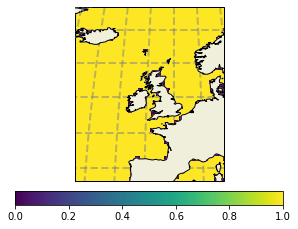

In [7]:
mapper(1*ds.maskC.isel(k=0),lon_0=-0,lat_bds=[40, 70],lon_bds=[-20, 10])

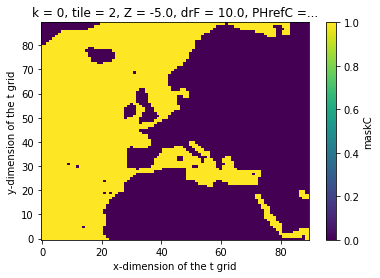

In [8]:
fig = ds.maskC.isel(k=0,tile=2).astype(float).plot()
#ds.maskC.isel(k=0,tile=2).astype(float).plot(col='tile',col_wrap=5)

In [9]:
grid = xgcm.Grid(ds)

In [10]:
# the following 5 lines will give you a UK edge mask, where the 1's are all on UK land
#edge_mask = ecco.scalar_calc.get_edge_mask(ds.maskC.isel(k=0),grid)
#edge_mask_UK = edge_mask.where(ds.XC<3,0)
#edge_mask_UK = edge_mask_UK.where(ds.XC>-6,0)
#edge_mask_UK = edge_mask_UK.where(ds.YC>50.5,0)
#edge_mask_UK = edge_mask_UK.where(ds.YC<60,0)

In [11]:
edge_mask = ecco.scalar_calc.get_edge_mask(1-ds.maskC.isel(k=0),grid)

In [12]:
edge_mask_UK = edge_mask.where(ds.XC<3,0)
edge_mask_UK = edge_mask_UK.where(ds.XC>-7,0)
edge_mask_UK = edge_mask_UK.where(ds.YC>49.5,0)
edge_mask_UK = edge_mask_UK.where(ds.YC<60,0)

# mask for eliminating boundary arising from continental Europe
tmp_mask = ds.maskC.isel(k=0).where(ds.YC<50,0)
tmp_mask = tmp_mask.where(ds.XC>-3,0)

# mask for eliminating boundary arising from Ireland
tmp_mask2 = ds.maskC.isel(k=0).where(ds.YC<54.5,0)
tmp_mask2 = tmp_mask2.where(ds.YC>53,0)
tmp_mask2 = tmp_mask2.where(ds.XC<-4,0)

edge_mask_UK = edge_mask_UK.where(1-tmp_mask,0)
edge_mask_UK = edge_mask_UK.where(1-tmp_mask2,0)

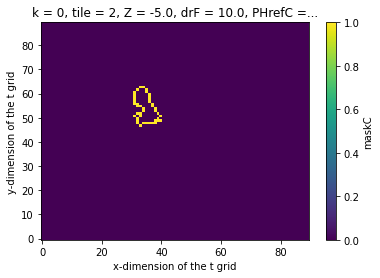

In [13]:
edge_mask_UK.isel(tile=2).plot()

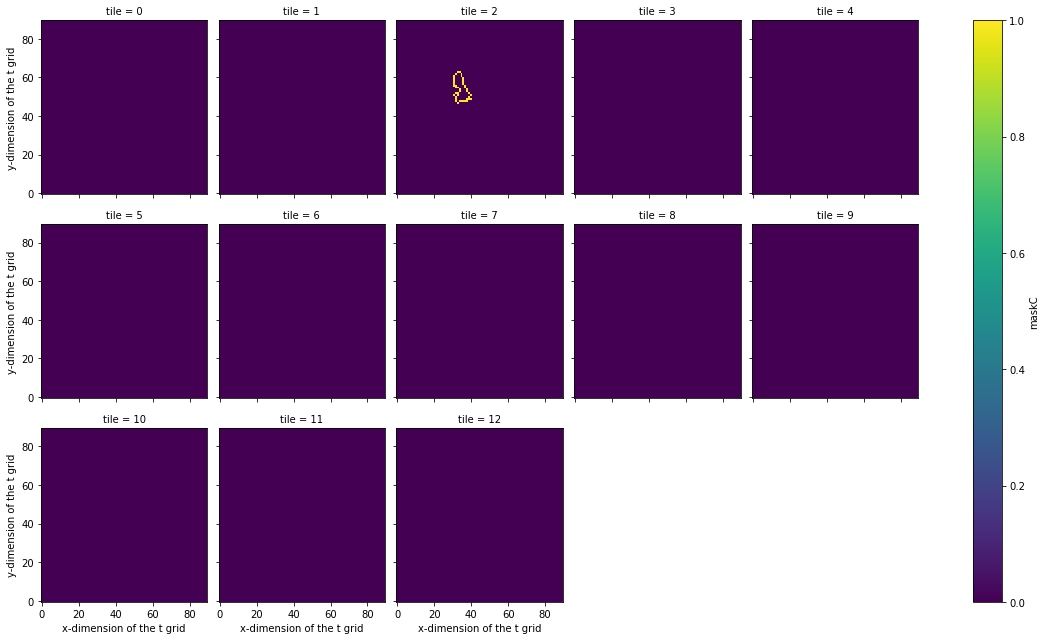

In [14]:
edge_mask_UK.plot(col='tile',col_wrap=5)
#edge_mask_UK.isel(tile=2).plot()

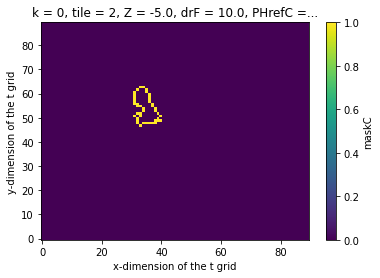

In [21]:
testmask = edge_mask_UK * ds.maskC.isel(k=0).astype(float)
#testmask.plot(col='tile',col_wrap=5)
testmask.isel(tile=2).plot()
plt.savefig('figures/UK_coast_mask_noLand.png',dpi=200,bbox_inches='tight',pad_inches=0)

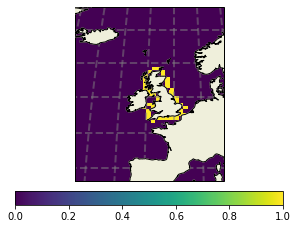

In [20]:
#fig,axs = plt.subplots(1,2,figsize=(20,10))
#testmask.isel(tile=2).plot(ax=axs[0])
mapper(edge_mask_UK.astype('float'),lon_0=-0,lat_bds=[40, 70],lon_bds=[-20, 10])
plt.savefig('figures/UK_coast_mask.png',dpi=200,bbox_inches='tight',pad_inches=0)

In [ ]:
extra_metadata = xmitgcm.utils.get_extra_metadata(domain='llc', nx=90)
extra_metadata

In [ ]:
edge_mask_UK = edge_mask_UK.rename({'tile':'face'})

In [ ]:
facets = xmitgcm.utils.rebuild_llc_facets(edge_mask_UK, extra_metadata)
facets

In [ ]:
xmitgcm.utils
#llc_facets_2d_to_compact?

In [ ]:
compact = xmitgcm.utils.llc_facets_2d_to_compact(facets, extra_metadata)

In [ ]:
np.sum(np.isnan(compact))

In [ ]:
xmitgcm.utils.write_to_binary(compact, 'datasets/UK_coast_C')

In [ ]:
# to read this again, do
# mask = ecco_v4_py.read_llc_to_tiles('datasets/','UK_coast_C')
# mask = ecco_v4_py.llc_tiles_to_xda(mask,var_type='c')